In [1]:
%matplotlib inline
from LRGSG_package.LRGSG import *
#
move_to_rootf(print_tf=True)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [2]:
l = Lattice3D(dim=(3, 3, 3), geo='bcc', pbc=True, pflip=0.2,
              theta=np.pi/7, phi=np.pi/8,
              with_positions=True)
# l.flip_sel_edges(l.nwDict['rand']['G'])

/home/opisthofulax/anaconda3/envs/LRG-Signed/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


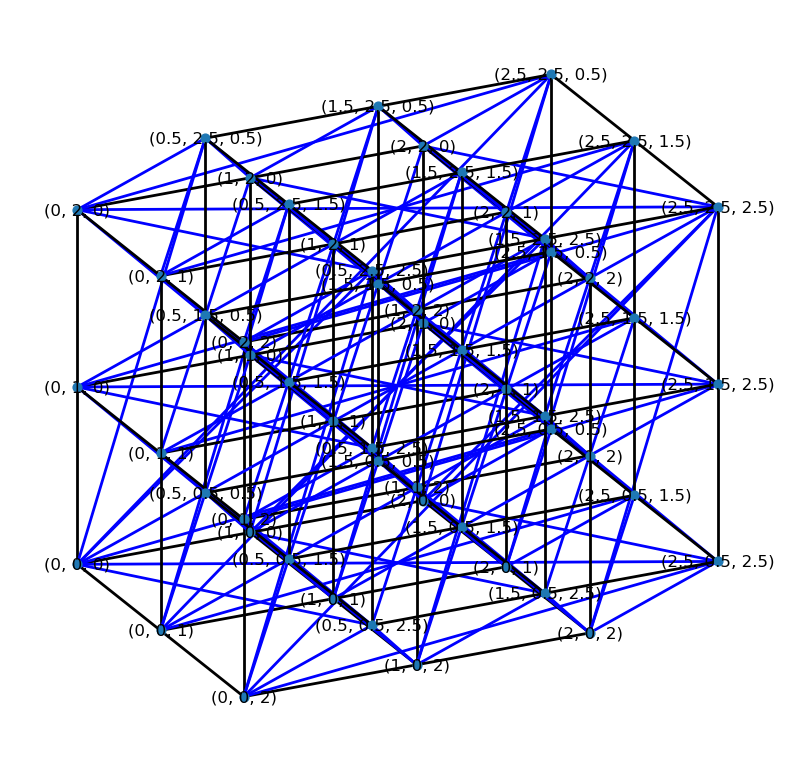

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
# l._set_positions(np.pi/3, np.pi/6)
colors = ['blue' if l.G[u][v]['type'] == 'link' else 'k' for u, v in l.G.edges()]

nx.draw(l.G, pos=l.get_node_pos(), edge_color=colors, cmap='red_blue', width=2, node_size=40, with_labels=True)

In [7]:
degree_count = {node: 0 for node in l.G.nodes()}

# Iterate over all edges in the graph
for u, v, data in l.G.edges(data=True):
    # Check if the edge is of the desired type
    if data.get('type') == 'link':
        # If so, increment the degree count for both nodes connected by this edge
        degree_count[u] += 1
        degree_count[v] += 1

# degree_count now contains the degree of each node based on type 1 links only
print(np.where(np.array(list(degree_count.values())) <8)[0])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 15 18 19 20 21 24 29 32 33 34 35
 38 41 42 43 44 45 46 47 48 49 50 51 52 53]


In [5]:
list(degree_count.values())

[7,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 8,
 8,
 5,
 8,
 8,
 5,
 5,
 5,
 5,
 8,
 8,
 5,
 8,
 8,
 8,
 8,
 5,
 8,
 8,
 5,
 5,
 5,
 5,
 8,
 8,
 5,
 8,
 8,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 7]

In [11]:
list(l.G.nodes())

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 1.5),
 (0.5, 0.5, 2.5),
 (0.5, 1.5, 0.5),
 (0.5, 1.5, 1.5),
 (0.5, 1.5, 2.5),
 (0.5, 2.5, 0.5),
 (0.5, 2.5, 1.5),
 (0.5, 2.5, 2.5),
 (1.5, 0.5, 0.5),
 (1.5, 0.5, 1.5),
 (1.5, 0.5, 2.5),
 (1.5, 1.5, 0.5),
 (1.5, 1.5, 1.5),
 (1.5, 1.5, 2.5),
 (1.5, 2.5, 0.5),
 (1.5, 2.5, 1.5),
 (1.5, 2.5, 2.5),
 (2.5, 0.5, 0.5),
 (2.5, 0.5, 1.5),
 (2.5, 0.5, 2.5),
 (2.5, 1.5, 0.5),
 (2.5, 1.5, 1.5),
 (2.5, 1.5, 2.5),
 (2.5, 2.5, 0.5),
 (2.5, 2.5, 1.5),
 (2.5, 2.5, 2.5)]

In [8]:
np.array(list(l.G.nodes))[np.where(np.array(list(degree_count.values())) != 8)[0]]

array([[0. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 2. ],
       [0. , 1. , 0. ],
       [0. , 1. , 1. ],
       [0. , 1. , 2. ],
       [0. , 2. , 0. ],
       [0. , 2. , 1. ],
       [0. , 2. , 2. ],
       [1. , 0. , 0. ],
       [1. , 0. , 1. ],
       [1. , 0. , 2. ],
       [1. , 1. , 0. ],
       [1. , 2. , 0. ],
       [2. , 0. , 0. ],
       [2. , 0. , 1. ],
       [2. , 0. , 2. ],
       [2. , 1. , 0. ],
       [2. , 2. , 0. ],
       [0.5, 0.5, 2.5],
       [0.5, 1.5, 2.5],
       [0.5, 2.5, 0.5],
       [0.5, 2.5, 1.5],
       [0.5, 2.5, 2.5],
       [1.5, 0.5, 2.5],
       [1.5, 1.5, 2.5],
       [1.5, 2.5, 0.5],
       [1.5, 2.5, 1.5],
       [1.5, 2.5, 2.5],
       [2.5, 0.5, 0.5],
       [2.5, 0.5, 1.5],
       [2.5, 0.5, 2.5],
       [2.5, 1.5, 0.5],
       [2.5, 1.5, 1.5],
       [2.5, 1.5, 2.5],
       [2.5, 2.5, 0.5],
       [2.5, 2.5, 1.5],
       [2.5, 2.5, 2.5]])

In [7]:
dict(l.G.degree()).values()

dict_values([8, 8, 7, 8, 10, 9, 7, 9, 8, 9, 10, 9, 10, 14, 13, 9, 13, 12, 8, 9, 8, 9, 13, 12, 8, 12, 11, 11, 12, 8, 12, 13, 9, 8, 9, 8, 12, 13, 9, 13, 14, 10, 9, 10, 9, 8, 9, 7, 9, 10, 8, 7, 8, 8])

In [12]:
import numpy as np
import networkx as nx
from itertools import product

class LatticeGenerator:
    def __init__(self, dim, pbc=True):
        self.dim = dim
        self.pbc = pbc

    def _wrap_coordinate(self, coord):
        """Wrap coordinates according to PBC and lattice dimensions."""
        return tuple(c % d for c, d in zip(coord, self.dim))

    def _generate_fcc_lattice(self):
        G = nx.Graph()
        
        # Offsets for FCC lattice to include face-centered points
        fcc_offsets = [(0, 0, 0), (0.5, 0.5, 0), (0.5, 0, 0.5), (0, 0.5, 0.5)]

        # Generate all nodes, considering PBC for wrapping
        nodes = set(self._wrap_coordinate((x + ox, y + oy, z + oz))
                    for x, y, z in product(range(self.dim[0]), range(self.dim[1]), range(self.dim[2]))
                    for ox, oy, oz in fcc_offsets)

        G.add_nodes_from(nodes)

        # Pre-calculate wrapped neighbors for each node considering PBC
        node_list = list(G.nodes())
        for nd in node_list:
            for ox, oy, oz in fcc_offsets:
                for dx, dy, dz in [(-0.5, -0.5, 0), (-0.5, 0.5, 0), (0.5, -0.5, 0), (0.5, 0.5, 0),
                                   (-0.5, 0, -0.5), (-0.5, 0, 0.5), (0.5, 0, -0.5), (0.5, 0, 0.5),
                                   (0, -0.5, -0.5), (0, -0.5, 0.5), (0, 0.5, -0.5), (0, 0.5, 0.5)]:
                    # Wrap neighbor coordinates considering PBC
                    neighbor = self._wrap_coordinate((nd[0] + ox + dx, nd[1] + oy + dy, nd[2] + oz + dz))
                    if neighbor in nodes and neighbor != nd:
                        G.add_edge(nd, neighbor)

        return G

# Example usage
dim = (4, 4, 4)  # Specify dimensions of the FCC lattice
lattice_gen = LatticeGenerator(dim)
G = lattice_gen._generate_fcc_lattice()

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 256
Number of edges: 5376


In [15]:
dict(G.degree()).values()

dict_values([42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,